True Flux formula:
$$F_{int}(\lambda) = F_{obs}(\lambda) \times 10^{0.4 \cdot A_\lambda}$$

Where:
$$A_\lambda = E(B-V) \cdot [R_V \cdot a(\lambda) + b(\lambda)]$$

In [39]:
import pandas as pd
import numpy as np
import gc

from pathlib import Path

import sys
import os

sys.path.append(os.path.abspath('..'))

RAW_DATA_PATH = Path("../data/raw")
PROCESSED_DATA_PATH = Path("../data/processed")

# Extinction coefficients for different filters
# Used for calculating true Flux
EXTINCTION_COEFFS = {
    'u': 4.81,
    'g': 3.64,
    'r': 2.70,
    'i': 2.06,
    'z': 1.58,
    'y': 1.31
}

In [40]:
# To tackle faint TDEs
def calculate_temperature_proxy(df):
    # 1. Mean Color (Static Temperature)
    # Higher value = Bluer (Hotter)
    # If 'u' is much brighter than 'g', this ratio is high.
    df['color_u_div_g'] = df['Flux_corrected_mean_u'] / (df['Flux_corrected_mean_g'] + 1e-6)

    # 2. Color Evolution (The "Cooling Rate")
    # TDEs cool slowly (stay blue). SNe cool fast (turn red).
    # We compare color at Peak vs. Color Late-time.
    
    # Simple proxy: (Max u / Max g) - (Mean u / Mean g)
    # If positive: It was bluer at peak than on average (Typical behavior)
    # If near zero: Temperature stayed constant (TDE characteristic)
    ratio_peak = df['Flux_corrected_max_u'] / (df['Flux_corrected_max_g'] + 1e-6)
    ratio_mean = df['Flux_corrected_mean_u'] / (df['Flux_corrected_mean_g'] + 1e-6)
    
    df['color_change_u_g'] = ratio_peak - ratio_mean
    
    return df

In [41]:
def calculate_shape_features(df):
    # "Plumpness" (Area under curve relative to Peak)
    # A spike is thin. A sustained event is plump.
    # Formula: Mean Flux / Max Flux
    # For a square wave = 1.0. For a delta spike ~ 0.
    
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        col_mean = f'Flux_corrected_mean_{band}'
        col_max = f'Flux_corrected_max_{band}'
        
        # This feature is 100% independent of distance/brightness
        # If it's a TDE, this value should be consistent whether it's z=0.1 or z=1.0
        df[f'shape_plumpness_{band}'] = df[col_mean] / (df[col_max] + 1e-6)
        
    return df

In [42]:
# A simplified "Decay Rate" feature
# Compare Flux at Peak vs Flux at the end of the window

def calculate_decay_strength(df):
    for band in ['u', 'g']: # Focus on blue bands where TDEs live
        # Ratio of Min (late-time) to Max (peak)
        # Low value = Faded away completely
        # High value = Still glowing (Plateau)
        col_min = f'Flux_corrected_min_{band}'
        col_max = f'Flux_corrected_max_{band}'
        
        df[f'decay_ratio_{band}'] = df[col_min] / (df[col_max] + 1e-6)

    return df

In [43]:
def feature_extraction(raw_path, train=True):
    # Setup paths
    prefix = "train_" if train else "test_"
    log_file_path = raw_path / (prefix + "log.csv")
    
    # Master metadata
    log_df = pd.read_csv(log_file_path)
    # Drop non-essential columns, keep Z/Z_err for final merge
    log_df = log_df.drop(columns=["English Translation", "split", "SpecType"], errors='ignore')

    processed_chunks = []
    
    # Loop through 20 splits
    for i in range (1, 21):
        folder_name = f"split_{i:02d}"
        file_path = raw_path / folder_name / (prefix + "full_lightcurves.csv")
        
        print(f"Processing {folder_name}...")
        
        # Load lightcurves
        chunk_df = pd.read_csv(file_path)
        chunk_df = chunk_df.dropna(subset=['Flux'])
        
        # Merge metadata for Extinction Correction
        # We only need EBV here; Z is better used at the very end to save memory
        chunk_df = chunk_df.merge(log_df[['object_id', 'EBV']], on="object_id", how="left")
        
        # == Step 1: Extinction Correction ==
        extinction_factors = chunk_df["Filter"].map(EXTINCTION_COEFFS)
        chunk_df["Total_extinction"] = extinction_factors * chunk_df["EBV"]
        
        chunk_df["Flux_corrected"] = chunk_df["Flux"] * 10**(0.4 * chunk_df["Total_extinction"])
        chunk_df["Flux_err_corrected"] = chunk_df["Flux_err"] * 10**(0.4 * chunk_df["Total_extinction"])
        chunk_df["SNR_obs"] = chunk_df["Flux_corrected"] / chunk_df["Flux_err_corrected"]
        
        # == Step 2: Extract Time & Variability Features ==
        chunk_df = chunk_df.sort_values(by=["object_id", "Time (MJD)"])
        
        # Relative Time
        start_times = chunk_df.groupby('object_id')['Time (MJD)'].transform('min')
        chunk_df['Time_relative'] = chunk_df['Time (MJD)'] - start_times
        
        # Delta calculations (vectorized)
        chunk_df["Delta_time"] = chunk_df.groupby(["object_id", "Filter"])["Time_relative"].diff().fillna(0)
        chunk_df["Delta_flux"] = chunk_df.groupby(["object_id", "Filter"])["Flux_corrected"].diff()
        
        # NEW: Delta Flux Squared (For Von Neumann Ratio)
        # This is the numerator for the smoothness metric
        chunk_df["Delta_flux_sq"] = chunk_df["Delta_flux"] ** 2
        
        # Flux change rate
        chunk_df["Flux_change_rate"] = chunk_df["Delta_flux"] / chunk_df["Delta_time"].replace(0, np.nan)
        chunk_df["Flux_change_rate"] = chunk_df["Flux_change_rate"].fillna(0)
        
        # == Step 3: Statistical Aggregations ==
        
        # 3a. Extract Max/Min Indices
        idx_max = chunk_df.groupby(['object_id', 'Filter'])['Flux_corrected'].idxmax().dropna()
        idx_min = chunk_df.groupby(['object_id', 'Filter'])['Flux_corrected'].idxmin().dropna()
        
        # Extract Times
        time_max = chunk_df.loc[idx_max, ['object_id', 'Filter', 'Time_relative']].pivot(
            index='object_id', columns='Filter', values='Time_relative').add_prefix('Time_of_max_flux_')
        
        time_min = chunk_df.loc[idx_min, ['object_id', 'Filter', 'Time_relative']].pivot(
            index='object_id', columns='Filter', values='Time_relative').add_prefix('Time_of_min_flux_')

        # 3b. Main Aggregations
        aggs = {
            'Flux_corrected': ['mean', 'max', 'min', 'std', 'skew'],
            'Flux_change_rate': ['mean', 'max', 'std'], 
            'Time_relative': ['max', 'count'],
            'Flux_err_corrected': ['mean'],
            'SNR_obs': ['max'],
            'Delta_flux_sq': ['mean'] # Aggregating the squared differences
        }
        
        agg_df = chunk_df.groupby(['object_id', 'Filter']).agg(aggs)
        features_df = agg_df.unstack(level='Filter')
        
        # Flatten Columns
        features_df.columns = [f"{c[0]}_{c[1]}_{c[2]}" for c in features_df.columns]
        features_df = features_df.reset_index()
        
        # Fill Counts
        count_cols = [c for c in features_df.columns if '_count_' in c]
        features_df[count_cols] = features_df[count_cols].fillna(0)
        
        # Merge Times
        features_df = features_df.merge(time_max, on='object_id', how='left')
        features_df = features_df.merge(time_min, on='object_id', how='left')

        # == Step 4: Feature Engineering (The Physics) ==
        
        bands = ['u', 'g', 'r']
        
        # Von Neumann Ratio (Smoothness)
        for b in bands:
            delta_sq_mean = f"Delta_flux_sq_mean_{b}"
            flux_std = f"Flux_corrected_std_{b}"
            
            if delta_sq_mean in features_df.columns and flux_std in features_df.columns:
                # Variance = std^2
                variance = features_df[flux_std] ** 2
                # Add epsilon to avoid divide by zero
                features_df[f"von_neumann_{b}"] = features_df[delta_sq_mean] / (variance + 1e-9)

        # Blue/Red Energy Ratio (Temperature)
        # Measures fraction of energy in High Energy bands (u, g) vs Low Energy (r, i, z, y)
        blue_cols = [f"Flux_corrected_mean_{b}" for b in ['u', 'g'] if f"Flux_corrected_mean_{b}" in features_df.columns]
        red_cols  = [f"Flux_corrected_mean_{b}" for b in ['r'] if f"Flux_corrected_mean_{b}" in features_df.columns]
        
        if blue_cols and red_cols:
            features_df['flux_blue_sum'] = features_df[blue_cols].sum(axis=1)
            features_df['flux_red_sum'] = features_df[red_cols].sum(axis=1)
            features_df['blue_red_ratio'] = features_df['flux_blue_sum'] / (features_df['flux_red_sum'] + 1e-6)

        # Existing Ratios (Rise/Decay, Amplitude, Color)
        for b in bands:
            # Rise/Decay
            t_max = f"Time_of_max_flux_{b}"
            t_total = f"Time_relative_max_{b}"
            if t_max in features_df.columns and t_total in features_df.columns:
                 features_df[f"rise_decay_ratio_{b}"] = features_df[t_max] / ((features_df[t_total] - features_df[t_max]) + 1e-6)
            
            # Amplitude
            f_max = f"Flux_corrected_max_{b}"
            f_min = f"Flux_corrected_min_{b}"
            if f_max in features_df.columns and f_min in features_df.columns:
                features_df[f"amplitude_{b}"] = features_df[f_max] - features_df[f_min]

        # Colors (e.g., u-g, g-r)
        for b1, b2 in zip(bands[:-1], bands[1:]):
            c1 = f"Flux_corrected_mean_{b1}"
            c2 = f"Flux_corrected_mean_{b2}"
            if c1 in features_df.columns and c2 in features_df.columns:
                features_df[f"color_{b1}_{b2}"] = features_df[c1] - features_df[c2]

        processed_chunks.append(features_df)
        
        # Memory Cleanup
        del chunk_df, agg_df, features_df
        gc.collect()

    print("Concatenating chunks...")
    final_df = pd.concat(processed_chunks)
    
    # == Step 5: Final Merge and Physics with Redshift ==
    final_df = final_df.merge(log_df, on='object_id', how='left')
    
    # NEW: Luminosity Proxy (Absolute Magnitude Approximation)
    # L ~ Flux * Distance^2 (using Z as proxy for distance)
    # Important: High Z + High Flux = Extremely Luminous Object (TDE)
    if 'Z' in final_df.columns:
        final_df['z_distance_proxy'] = final_df['Z'] ** 2
        for b in ['g', 'r', 'i']: # Main optical bands
            if f"Flux_corrected_max_{b}" in final_df.columns:
                final_df[f"luminosity_max_{b}"] = final_df[f"Flux_corrected_max_{b}"] * final_df['z_distance_proxy']

    print("Processing complete.")
    return final_df

In [44]:
# Process training data
train_features = feature_extraction(RAW_DATA_PATH, train=True)

Processing split_01...
Processing split_02...
Processing split_03...
Processing split_04...
Processing split_05...
Processing split_06...
Processing split_07...
Processing split_08...
Processing split_09...
Processing split_10...
Processing split_11...
Processing split_12...
Processing split_13...
Processing split_14...
Processing split_15...
Processing split_16...
Processing split_17...
Processing split_18...
Processing split_19...
Processing split_20...
Concatenating chunks...
Processing complete.


In [45]:
train_features.head()


,object_id,Flux_corrected_mean_g,Flux_corrected_mean_i,Flux_corrected_mean_r,Flux_corrected_mean_u,Flux_corrected_mean_y,Flux_corrected_mean_z,Flux_corrected_max_g,Flux_corrected_max_i,Flux_corrected_max_r,...,color_u_g,color_g_r,Z,Z_err,EBV,target,z_distance_proxy,luminosity_max_g,luminosity_max_r,luminosity_max_i
0,Dornhoth_fervain_onodrim,-0.541341,2.601577,1.412578,0.950745,-0.458879,1.489760,1.424000,28.277937,13.802700,...,1.492086,-1.953919,3.0490,NaN,0.110,0,9.296401,13.238073,128.315432,262.883046
1,Dornhoth_galadh_ylf,0.218875,0.394725,0.317303,0.034930,0.757253,0.573209,1.518313,5.797249,3.027457,...,-0.183944,-0.098428,0.4324,NaN,0.058,0,0.186970,0.283879,0.566043,1.083910
2,Elrim_melethril_thul,3.757406,7.781453,5.462329,0.078012,0.065533,9.287801,8.691179,14.758927,11.552149,...,-3.679394,-1.704923,0.4673,NaN,0.577,0,0.218369,1.897887,2.522635,3.222896
3,Ithil_tobas_rodwen,0.289940,0.455992,0.448044,0.161333,0.348274,0.540509,1.425550,2.269820,1.922080,...,-0.128607,-0.158104,0.6946,NaN,0.012,0,0.482469,0.687784,0.927345,1.095118
4,Mirion_adar_Druadan,0.056120,0.428605,0.242114,-0.018189,0.308948,0.322406,1.798828,6.010829,2.709919,...,-0.074308,-0.185994,0.4161,NaN,0.058,0,0.173139,0.311448,0.469193,1.040710


In [46]:
# Verify that we have collapsed the time-series
is_unique = train_features.index.is_unique  # If object_id is the index
# OR
# is_unique = train_features['object_id'].is_unique 

if is_unique:
    print(f"Data is correctly aggregated. Shape: {train_features.shape}")
else:
    print("CRITICAL ERROR: You still have multiple rows per object.")

Data is correctly aggregated. Shape: (3043, 113)


In [47]:
print("Available columns are:", train_features.columns.tolist())

Available columns are: ['object_id', 'Flux_corrected_mean_g', 'Flux_corrected_mean_i', 'Flux_corrected_mean_r', 'Flux_corrected_mean_u', 'Flux_corrected_mean_y', 'Flux_corrected_mean_z', 'Flux_corrected_max_g', 'Flux_corrected_max_i', 'Flux_corrected_max_r', 'Flux_corrected_max_u', 'Flux_corrected_max_y', 'Flux_corrected_max_z', 'Flux_corrected_min_g', 'Flux_corrected_min_i', 'Flux_corrected_min_r', 'Flux_corrected_min_u', 'Flux_corrected_min_y', 'Flux_corrected_min_z', 'Flux_corrected_std_g', 'Flux_corrected_std_i', 'Flux_corrected_std_r', 'Flux_corrected_std_u', 'Flux_corrected_std_y', 'Flux_corrected_std_z', 'Flux_corrected_skew_g', 'Flux_corrected_skew_i', 'Flux_corrected_skew_r', 'Flux_corrected_skew_u', 'Flux_corrected_skew_y', 'Flux_corrected_skew_z', 'Flux_change_rate_mean_g', 'Flux_change_rate_mean_i', 'Flux_change_rate_mean_r', 'Flux_change_rate_mean_u', 'Flux_change_rate_mean_y', 'Flux_change_rate_mean_z', 'Flux_change_rate_max_g', 'Flux_change_rate_max_i', 'Flux_change_rate

In [48]:
test_features = feature_extraction(RAW_DATA_PATH, train=False)

Processing split_01...
Processing split_02...
Processing split_03...
Processing split_04...
Processing split_05...
Processing split_06...
Processing split_07...
Processing split_08...
Processing split_09...
Processing split_10...
Processing split_11...
Processing split_12...
Processing split_13...
Processing split_14...
Processing split_15...
Processing split_16...
Processing split_17...
Processing split_18...
Processing split_19...
Processing split_20...
Concatenating chunks...
Processing complete.


In [49]:
train_features.to_parquet(PROCESSED_DATA_PATH / "train_features.parquet", index=False)
test_features.to_parquet(PROCESSED_DATA_PATH / "test_features.parquet", index=False)

Found 28 highly correlated features (>90%):
['Flux_corrected_mean_r', 'Flux_corrected_mean_z', 'Flux_corrected_std_g', 'Flux_corrected_std_u', 'Flux_corrected_std_z', 'Time_relative_max_i', 'Time_relative_max_r', 'Time_relative_max_u', 'Time_relative_max_y', 'Time_relative_max_z', 'Time_relative_count_i', 'Time_relative_count_r', 'Time_relative_count_u', 'Time_relative_count_y', 'Time_relative_count_z', 'Flux_err_corrected_mean_u', 'SNR_obs_max_i', 'SNR_obs_max_r', 'SNR_obs_max_u', 'SNR_obs_max_y', 'SNR_obs_max_z', 'flux_blue_sum', 'flux_red_sum', 'amplitude_u', 'amplitude_g', 'amplitude_r', 'z_distance_proxy', 'luminosity_max_i']


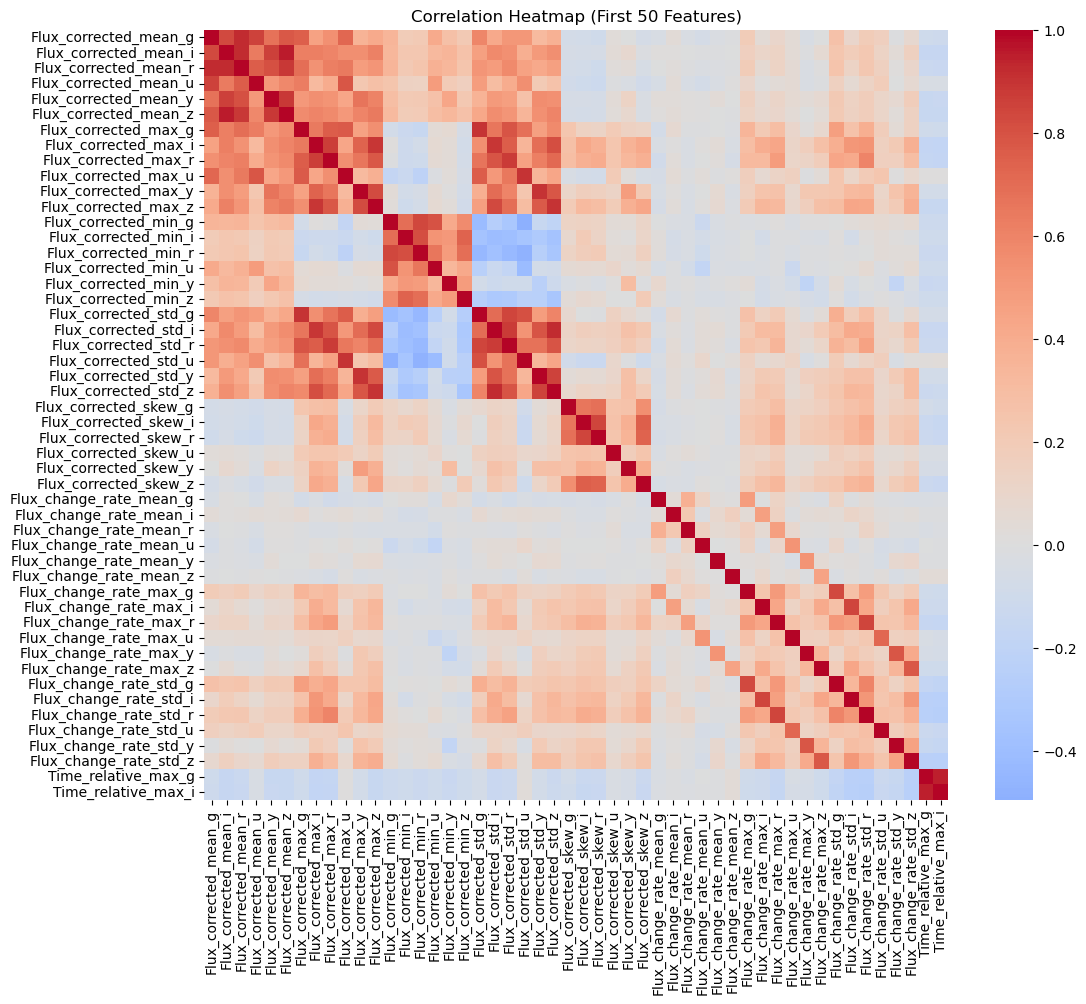

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_redundancy(df):
    # 1. Drop non-numeric columns for correlation
    numeric_df = df.drop(columns=['object_id', 'target', 'Z_err'], errors='ignore')
    
    # 2. Calculate Correlation Matrix
    corr_matrix = numeric_df.corr().abs()
    
    # 3. Select Upper Triangle of Correlation Matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # 4. Find Index of Feature Columns with Correlation > 0.90
    to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
    
    print(f"Found {len(to_drop)} highly correlated features (>90%):")
    print(to_drop)
    
    # 5. Plot Heatmap of Top Correlations
    plt.figure(figsize=(12, 10))
    # Plot only a subset if too many features exist
    subset_cols = numeric_df.columns[:50] 
    sns.heatmap(numeric_df[subset_cols].corr(), cmap='coolwarm', center=0)
    plt.title("Correlation Heatmap (First 50 Features)")
    plt.show()
    
    return to_drop

# Run Analysis
redundant_features = analyze_redundancy(train_features)

Training quick XGBoost to check importance...

Found 3 features with ZERO importance:
['z_distance_proxy', 'amplitude_g', 'flux_red_sum']


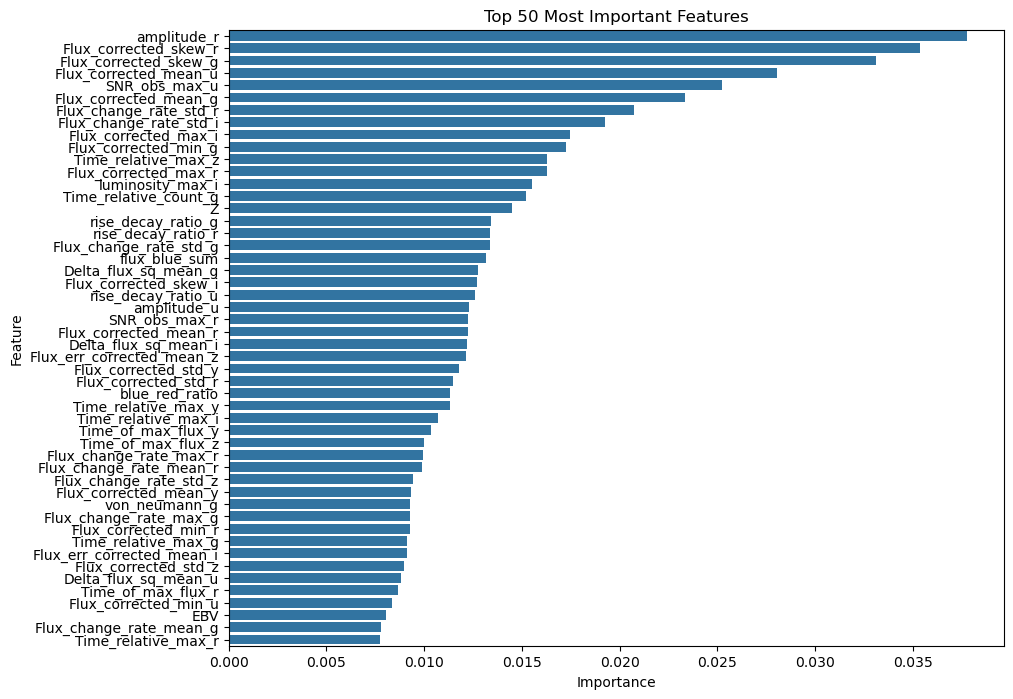

In [51]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

def check_feature_importance(df):
    # 1. Prepare Data
    X = df.drop(columns=['object_id', 'target', 'Z_err'], errors='ignore')
    y = df['target']
    
    # 2. Split (Quick 80/20 split just for checking)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 3. Train Quick Model
    print("Training quick XGBoost to check importance...")
    clf = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        n_jobs=-1,
        random_state=42
    )
    clf.fit(X_train, y_train)
    
    # 4. Extract Importance
    importance = clf.feature_importances_
    feature_names = X.columns
    
    # Create DataFrame
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    imp_df = imp_df.sort_values(by='Importance', ascending=False)
    
    # 5. Identify Zero Importance Features
    zero_imp = imp_df[imp_df['Importance'] == 0]['Feature'].tolist()
    
    print(f"\nFound {len(zero_imp)} features with ZERO importance:")
    print(zero_imp)
    
    # 6. Plot Top Features
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=imp_df.head(50))
    plt.title("Top 50 Most Important Features")
    plt.show()
    
    return zero_imp

# Run Analysis
useless_features = check_feature_importance(train_features)

In [52]:
# Combine lists
features_to_drop = list(set(redundant_features + useless_features))

print(f"Total Candidate Features to Drop: {len(features_to_drop)}")
print(features_to_drop)

Total Candidate Features to Drop: 28
['Time_relative_max_y', 'Flux_corrected_std_g', 'SNR_obs_max_i', 'SNR_obs_max_r', 'Time_relative_max_i', 'luminosity_max_i', 'Time_relative_max_r', 'flux_blue_sum', 'amplitude_u', 'amplitude_r', 'Time_relative_count_y', 'Time_relative_count_i', 'SNR_obs_max_u', 'Flux_corrected_std_z', 'Time_relative_count_u', 'z_distance_proxy', 'Flux_corrected_std_u', 'Time_relative_max_u', 'Flux_corrected_mean_r', 'Flux_err_corrected_mean_u', 'Time_relative_max_z', 'amplitude_g', 'Time_relative_count_z', 'flux_red_sum', 'SNR_obs_max_z', 'Time_relative_count_r', 'Flux_corrected_mean_z', 'SNR_obs_max_y']
